# Churn Analysis
Data retrieved from: https://www.ibm.com/communities/analytics/watson-analytics-blog/predictive-insights-in-the-telco-customer-churn-data-set/
> A telecommunications company is concerned about the number of customers leaving their landline business for cable competitors. They need to understand **who is leaving**.

**Why?**  
It is important for companies to asses whether a client is likely to leave or not; which variables have a bigger effect in churn; and what, if anything, retains the client.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from sklearn.model_selection import train_test_split
from collections import 

plt.rcParams["figure.figsize"] = (7, 3.5)
plt.rcParams["figure.dpi"] = 100

In [91]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin

class DataframeSelector(BaseEstimator, TransformerMixin):
    """
    ScikitLearn class to select a subset of the columns
    in a pandas dataframe 
    """
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns].values
    
class CategoricalDfImputer(BaseEstimator, TransformerMixin):
    """
    Impute missing values from a categorical pd.DataFrame
    
    Parameters
    ----------
    nan_threshold: if specified, columns with a percentage of nans
    greater than nan_threshold will be dropped.
    """
    def __init__(self, missing_values="NaN", nan_threshold=None):
        self.missing_values = missing_values
        self.nan_threshold = nan_threshold
    def fit(self, X, y=None):
        return self
    def transform (self, X):
        # Return a numpy array in the indices where the % of nans is greater than the stablished threshold
        void_cols = np.where(np.count_nonzero(pd.isna(X), axis=0) / X.shape[0] > self.nan_threshold)[0] \
                    if self.nan_threshold is not None else []
        Xout = np.empty_like(X, dtype="object")
        for i, col in enumerate(X.T):
            imputer = CategoricalImputer()
            cleaned_col = imputer.fit_transform(col)
            Xout[:, i] = cleaned_col
        Xout = Xout[:, [i for i in range(len(X.T)) if i not in void_cols]]
        return Xout

class LabelNdBinarizer(BaseEstimator, TransformerMixin):
    """
    Transorm a bi-dimensional categorical numpy array ('object'), i.e.,
    a Matrix, into a single OHE matrix.
    """
    def __init__(self):
        self.all_classes_ = []
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xout = None
        _, nfeats = X.shape
        for ix in range(nfeats):
            lab_bin = LabelBinarizer()
            bin_X = lab_bin.fit_transform(X[:, ix])
            self.all_classes_.append(lab_bin.classes_)
            if Xout is None:
                Xout = bin_X
            else:
                Xout = np.c_[Xout, bin_X]
        return Xout

Load the data and look at shape

In [63]:
url = "https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv"
r = requests.get(url)
churn = pd.read_csv(StringIO(r.text), na_values=" ")
churn.shape

(7043, 21)

In [79]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(2), ob

As always, we divide the data into train and test sets. We will only be working with our training dataset all all throughout the EDA and model evaluation.  

In [65]:
train, test = train_test_split(churn, test_size=0.2, random_state=42)
train.shape, test.shape

((5634, 21), (1409, 21))

Let us begin by looking at at the proportion of those who churn against those who did not churn.

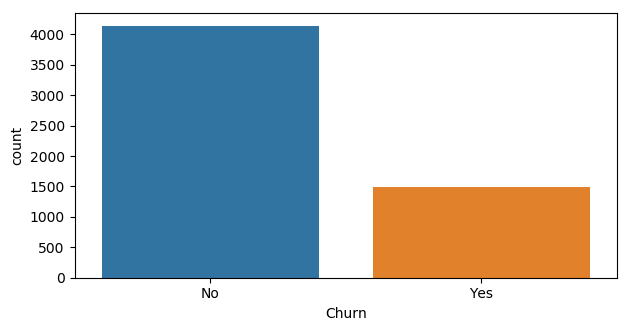

In [66]:
sns.countplot(x="Churn", data=train)

In [67]:
def plot_density_cat(df, contvar, catvar, **kwargs):
    """
    Plot a density distribution segregated by a categorical variable
    
    Parameters
    ----------
    df: DataFrame
    contvar: str
        Name of the continous variable
    catvar: str
        Name of the categorical variable 
        
    Returns
    -------
    None
        Plots the graph
    """
    categories = df[catvar].unique()
    for cat in categories:
        segregation = df.query(f"{catvar} == '{cat}'")[contvar]
        sns.distplot(segregation, hist_kws={"alpha":0.5,  "label":cat}, kde=False, norm_hist=True)
    plt.legend()

As a fist approximation to see what differentiates these two groups, lest's focus on the density of the Montly charges, segregated by those who churn and those who did not.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


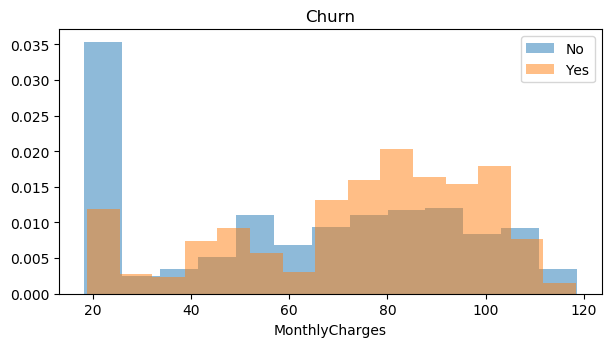

In [68]:
plot_density_cat(train, "MonthlyCharges", "Churn")
plt.title("Churn");

Those who churn seem to have a higher sample proportion in montly charges at around 70+, in contrast with those who stayed; meaning that the higher the montly charge, the higher the likelyhood of a person is to churn.

In [70]:
train.loc[:, "Churn_bool"] = train.Churn.apply(lambda r: 1 if r == "Yes" else 0)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


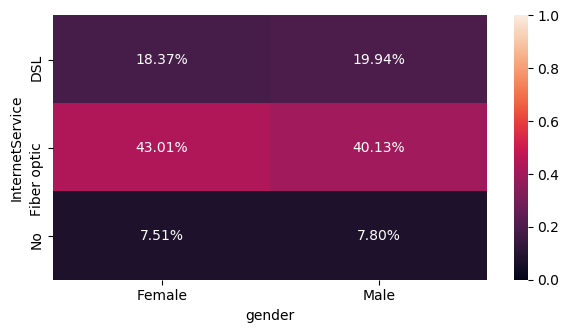

In [71]:
churned = train.pivot_table(values="Churn_bool", columns="gender", index="InternetService")
sns.heatmap(churned, annot=True, fmt="0.2%", vmin=0, vmax=1);

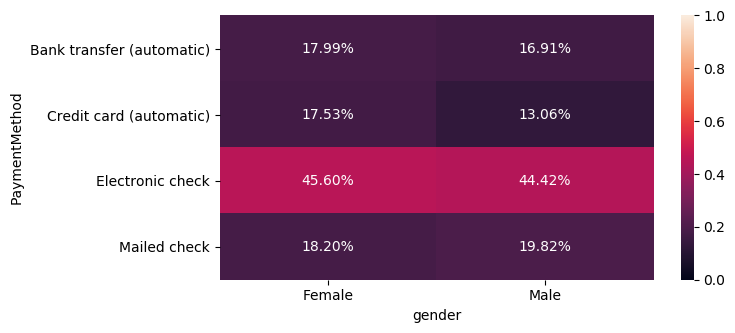

In [72]:
churned = train.pivot_table(values="Churn_bool", columns="gender", index="PaymentMethod")
sns.heatmap(churned, annot=True, fmt="0.2%", vmin=0, vmax=1);

As far as gender goes, there seems to be no clear distinction in churning rates. On the other hand, people with 'Electronic Check' as payment method do seem to have a significant higher churning rate than any other payment method

There seems to be a high churning ratio among those who pay with electronic check and have a Fiber optic as internet service

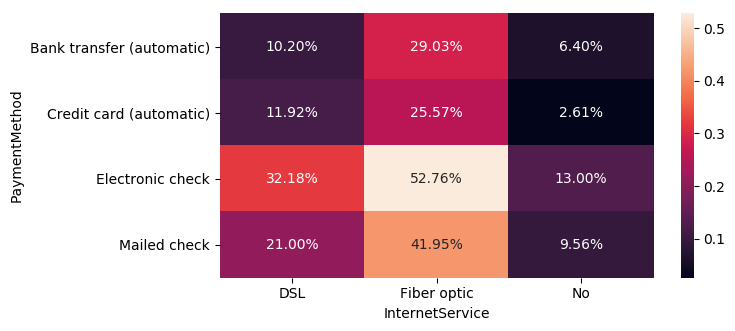

In [73]:
sns.heatmap(train.pivot_table(index="PaymentMethod", columns="InternetService", values="Churn_bool"),
            fmt="0.2%", annot=True)

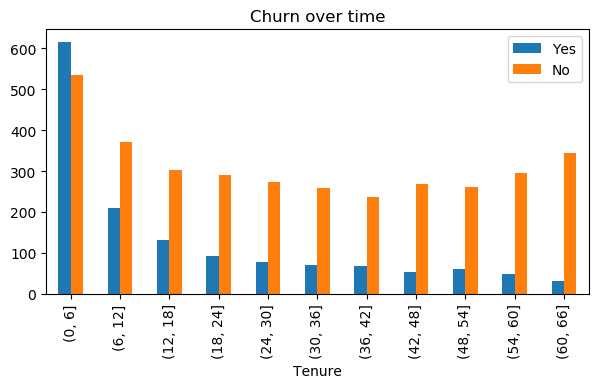

In [74]:
bins = [i * 6 for i in range(12)]
churn_yes = pd.value_counts(pd.cut(train.query("Churn == 'Yes'").tenure, bins))
churn_no = pd.value_counts(pd.cut(train.query("Churn == 'No'").tenure, bins))
churn_yes.name = "Yes"
churn_no.name = "No"
over_time_churn = pd.DataFrame([churn_yes, churn_no]).T
over_time_churn.plot(kind="bar", title="Churn over time")
plt.xlabel("Tenure");

As time passes, people who do not leave seem to be more likely to stay the periods thereafter.

## Onto the ML model!
### Decision Trees and Random Forests

In this segment we turn to the question *what is actually making customers who leave?* We will explore two related models: decision trees and random forests: an ensemble of decision trees.

**Decision Trees**  
Decicion trees are versitile and easy to interpret models. A telecomunications company migh be interested in this kind of models since it provides an easy-to-interpret overview of the problem.

The first step in building our model will be to create the pipeline in which the variables will be transformed and the model trained.

In [75]:
# Let us drop the variable we created for 
train.drop("Churn_bool", axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [99]:
cat_train = train.loc[:, train.dtypes == "object"].values

In [100]:
LabelNdBinarizer().fit_transform(cat_train)

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

dtree = DecisionTreeClassifier(max_depth=2)

In [115]:
X_train = train.drop(["customerID", "Churn"], axis=1)
y_train  = (train.Churn == "Yes") * 1

In [ ]:
void_cols = ["customerID", "Churn"]
features_dtype = 

In [117]:
dtree.fit(X_train, y_train)

ValueError: could not convert string to float: 'Credit card (automatic)'